# Intoduction to NLP - Final Project

In [1]:
#load libraries
import json
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import logging

from bs4 import BeautifulSoup
import requests
from datetime import datetime
import locale
from concurrent.futures import ThreadPoolExecutor
from lxml import html
from tqdm import tqdm
import time
from time import sleep

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.common.exceptions import NoSuchElementException, ElementClickInterceptedException, StaleElementReferenceException
from selenium.common.exceptions import TimeoutException
from selenium.common.exceptions import NoSuchElementException

import nltk
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

from wordcloud import WordCloud  # Import wordcloud package

## Web Scraping

In [2]:
#set paths
download_folder = './downloads'
gecko_driver_path = '/Users/amberwalker/Intro_text_nlp/ps1/geckodriver'
profile_path =  '/Users/amberwalker/Library/Application Support/Firefox/Profiles/9eq5v9xc.default-release-1'
link = 'https://www.fool.com/quote/nyse/rcl/'

### Custom functions for scraping the transcripts

In [19]:
def set_firefox_preferences(download_folder, profile_path, enable_download=False):
    """
    Configures Firefox preferences for Selenium WebDriver.
    """
    # Use the provided profile path
    profile = webdriver.FirefoxProfile(profile_path)

    # Set preferences
    profile.set_preference("browser.download.dir", download_folder)
    profile.set_preference("browser.download.folderList", 2)
    profile.set_preference("browser.download.manager.showWhenStarting", False)
    profile.set_preference("browser.helperApps.neverAsk.saveToDisk",
                           "application/msword,application/rtf,application/csv,text/csv,image/png,image/jpeg,application/pdf,text/html,text/plain,application/octet-stream")

    # Automatically download PDFs
    if enable_download:
        profile.set_preference("browser.helperApps.neverAsk.saveToDisk", "application/pdf,application/x-pdf")
        profile.set_preference("pdfjs.disabled", True)

    options = Options()
    options.profile = profile
    return options

def start_firefox(link, download_folder, gecko_driver_path, profile_path, enable_download=True):
    """
    Initializes a Firefox WebDriver session.
    """
    # Explicitly specify the path to the Firefox executable
    options = Options()
    options.binary_location = r"C:\Program Files\Mozilla Firefox\firefox.exe"

    # Ensure the download folder exists
    os.makedirs(download_folder, exist_ok=True)

    # Set Firefox preferences with the given profile
    options = set_firefox_preferences(download_folder, profile_path, enable_download)

    # Set up the service with the path to the geckodriver
    service = Service(executable_path=gecko_driver_path)
    browser = webdriver.Firefox(options=options, service=service)
    browser.get(link)
    time.sleep(5)  # Adjust sleep time as needed
    return browser

def perform_click_action(browser, xpath, click_type):
    """
    Tries to click on an element. If obscured, waits and retries.
    """
    attempt_count = 0
    while attempt_count < 15:
        if try_click_element(browser, xpath, click_type):
            return
        time.sleep(1)
        attempt_count += 1
    # Optional: Add warning sound or logging here if needed

def try_click_element(browser, xpath, click_type):
    """
    Attempts to click an element based on its type.
    """
    try:
        element = {
            "xpath": lambda: browser.find_element_by_xpath(xpath),
            "id": lambda: browser.find_element_by_id(xpath),
            "css": lambda: browser.find_element_by_css_selector(xpath),
            "class": lambda: browser.find_element_by_class_name(xpath),
            "link": lambda: browser.find_element_by_link_text(xpath)
        }.get(click_type, lambda: None)()

        if element:
            element.click()
            return True
    except (ElementClickInterceptedException, NoSuchElementException, StaleElementReferenceException) as e:
        print(f"Error encountered: {e}")
    return False


def scrape_transcript(browser, url):
    browser.get(url)
    time.sleep(10)  # Consider using WebDriverWait for better accuracy.
    
    try:
        title = browser.find_element(By.XPATH, "//h1[contains(@class, 'font-medium')]").text
    except Exception as e:
        logging.error(f"Error finding title: {e}")
        title = "Title not found"
        
    try:
        date = browser.find_element(By.XPATH, "//div[contains(@class, 'text-lg font-medium')]").text.split('–')[1].strip()
    except Exception as e:
        logging.error(f"Error finding date: {e}")
        date = "Date not found"
#     # Extract the title and date of the transcript
#     title = browser.find_element(By.XPATH, "//h1[contains(@class, 'font-medium')]").text
#     date = browser.find_element(By.XPATH, "//div[contains(@class, 'text-lg font-medium')]").text.split('–')[1].strip()

    # Initialize variables to hold the CEO and CFO texts
    ceo_text = ""
    cfo_text = ""
    # Flags to control the capturing state
    capturing_ceo = False
    capturing_cfo = False
    # Flags to ensure only the first speech is captured
    first_ceo_speech_captured = False
    first_cfo_speech_captured = False

    
    # Find all relevant elements
    elements = browser.find_elements(By.XPATH, "//*[self::em or self::p]")
    
    known_ceos = ["ArnoldDonald","Frank J. Del Rio", "Josh Weinstein", "Arnold Donald", "Frank Del Rio", "Michael Bayley", "Harry Sommer"]  # Add known CEO names
    known_cfos = ["Mark A. Kempa", "Mark Kempa", "Jason Liberty", "Naftali Holtz", "David Bernstein"]  # Add known CFO names
    ceo_keywords = ["President and Chief Executive Officer, Norwegian Cruise Line Holdings", "Chief Executive Officer", "CEO", "President", "President and Chief Executive Officer", "President & Chief Executive Officer"]
    cfo_keywords = ["Executive Vice President & Chief Financial Officer", "Executive Vice President, Chief Financial Officer", "Chief Financial Officer", "CFO", "Executive Vice President, Chief Financial Officer", "Chief Financial Officer and Chief Accounting Officer", "Executive Vice President and Chief Financial Officer"]


#     for element in elements:
#         # Check for CEO or CFO designation
#         if element.tag_name == "em":
#             if any(keyword in element.text for keyword in ceo_keywords) and not first_ceo_speech_captured:
#                 capturing_ceo = True
#                 capturing_cfo = False  # Ensure we're not capturing CFO speech simultaneously
#             elif any(keyword in element.text for keyword in cfo_keywords) and not first_cfo_speech_captured:
#                 capturing_cfo = True
#                 capturing_ceo = False  # Ensure we're not capturing CEO speech simultaneously

    for element in elements:
        if element.tag_name == "p":
            try:
                # Attempt to find a <strong> tag, which may contain the speaker's name
                strong_tag = element.find_element(By.TAG_NAME, "strong")
                speaker_name = strong_tag.text.strip()
            except:
                speaker_name = None

            try:
                # Attempt to find an <em> tag, which may contain the speaker's role
                em_tag = element.find_element(By.TAG_NAME, "em")
                speaker_role = em_tag.text.strip()
            except:
                speaker_role = None
        
        # Determine if the speaker is the CEO or CFO based on the role or name.
        if speaker_role:
            # Check if any of the known CEO titles are in the speaker's role
            if any(keyword in speaker_role for keyword in ceo_keywords):
                capturing_ceo = True
                capturing_cfo = False
                logging.info(f"Capturing CEO speech: {speaker_name}")
            # Check if any of the known CFO titles are in the speaker's role
            elif any(keyword in speaker_role for keyword in cfo_keywords):
                capturing_ceo = False
                capturing_cfo = True
                logging.info(f"Capturing CFO speech: {speaker_name}")

        elif speaker_name:
            if speaker_name in known_ceos:
                capturing_ceo = True
                capturing_cfo = False
                logging.info(f"Capturing CEO speech by name: {speaker_name}")
            elif speaker_name in known_cfos:
                capturing_ceo = False
                capturing_cfo = True
                logging.info(f"Capturing CFO speech by name: {speaker_name}")
        
        # Capture the speech text
        elif element.tag_name == "p" and (capturing_ceo or capturing_cfo):
            # Detect the ending <strong> tag within a paragraph
            if "<strong>" in element.get_attribute('innerHTML'):
                if capturing_ceo:
                    first_ceo_speech_captured = True  # Mark the end of the first CEO speech capture
                    capturing_ceo = False  # Stop capturing CEO speech
                if capturing_cfo:
                    first_cfo_speech_captured = True  # Mark the end of the first CFO speech capture
                    capturing_cfo = False  # Stop capturing CFO speech
                continue  # Skip this paragraph as it contains the ending <strong> tag
            # Append paragraph text to the corresponding speech
            if capturing_ceo:
                ceo_text += element.text + " "
            elif capturing_cfo:
                cfo_text += element.text + " "
    # Check if any text was captured
    if not ceo_text:
        logging.warning("No CEO text captured.")
    if not cfo_text:
        logging.warning("No CFO text captured.")

    #dictionary
    return {
        'title': title, 
        'date': date, 
        'ceo_text': ceo_text, 
        'cfo_text': cfo_text, 
        'link': url
    }

# Function that collects the link to then later open them 
def collect_transcript_links(browser):
    links = []
    try:
        # Initially collect available links before clicking "View More"
        transcript_elements = browser.find_elements(By.CSS_SELECTOR, 'a[data-track-category="quotepage_transcripts"]')
        links.extend([element.get_attribute('href') for element in transcript_elements])
        
        while True:
            # Try to click "View More" button to load more transcripts
            #view_more_button = browser.find_element(By.XPATH, "//span[contains(text(), 'View More RCL Earnings Transcripts')]")
            view_more_button = browser.find_element(By.XPATH, "//span[contains(text(), 'View More') and contains(text(), 'Earnings Transcripts')]")

            browser.execute_script("arguments[0].click();", view_more_button)
            time.sleep(2)  # Adjust based on actual page load time
            
            # Update the list of transcript elements after loading more
            new_transcript_elements = browser.find_elements(By.CSS_SELECTOR, 'a[data-track-category="quotepage_transcripts"]')
            new_links = [element.get_attribute('href') for element in new_transcript_elements]
            
            # Check if new links were added after clicking "View More"
            if len(new_links) > len(links):
                print(f"Collected {len(new_links) - len(links)} new links. Total collected: {len(new_links)}")
                links = new_links  # Update the links list with the new set of links
            else:
                # No new links were added indicating all links have been loaded or "View More" is not working as expected
                print("No new links collected. Assuming all links have been collected.")
                break
    
    except Exception as e:
        # Handle cases where "View More" button is not found or other errors occur
        print("No more 'View More' button found or an error occurred:", str(e))
    
    return links

# Example of re-finding an element before interacting with it
def find_element_again(browser, by, value):
    WebDriverWait(browser, 10).until(EC.presence_of_element_located((by, value)))
    return browser.find_element(by, value)

### Creates the Df, a loop through each link for each company, each time collecting the requested informations

In [20]:
companies = [
    {'symbol': 'RCL', 'url': 'https://www.fool.com/quote/nyse/rcl/'},
    {'symbol': 'CCL', 'url': 'https://www.fool.com/quote/nyse/ccl/'},
    {'symbol': 'NCLH', 'url': 'https://www.fool.com/quote/nyse/nclh/'}
]

data_list = [] #dictionary to store company info

for company in companies:
    # Extract company-specific information
    symbol = company['symbol']
    company_url = company['url']
    
    # Start up the browser for each company's URL
    browser = start_firefox(company_url, download_folder, gecko_driver_path, profile_path)
    
    # Collect transcript links (assuming this function is adapted to work with the current company URL)
    transcript_links = collect_transcript_links(browser)
    
    # Iterate through each link, scrape the data, and append to the data_list
    for link in transcript_links:
        full_link = company_url + link if link.startswith('/') else link
        transcript_data = scrape_transcript(browser, full_link)
        data_list.append(transcript_data)
    
    # Consider adding a delay or checking robots.txt to ensure compliance with the website's policies
    # Close the browser for the current company before moving on to the next
    browser.quit()

# Convert the list of dictionaries to a DataFrame after collecting all data
df_carnival_royal = pd.DataFrame(data_list)



Collected 4 new links. Total collected: 8
Collected 4 new links. Total collected: 12
Collected 4 new links. Total collected: 16
Collected 4 new links. Total collected: 20
Collected 2 new links. Total collected: 22
No new links collected. Assuming all links have been collected.


Collected 4 new links. Total collected: 8
Collected 4 new links. Total collected: 12
Collected 4 new links. Total collected: 16
Collected 4 new links. Total collected: 20
No new links collected. Assuming all links have been collected.


Collected 4 new links. Total collected: 8
Collected 4 new links. Total collected: 12
Collected 4 new links. Total collected: 16
Collected 3 new links. Total collected: 19
No new links collected. Assuming all links have been collected.


In [10]:
#store results to csv file
df_carnival_royal.to_csv('transcripts_carnival_royal.csv', index=False)

In [21]:
df_carnival_royal["ceo_text"]

0     Good morning, everyone, and thank you for join...
1     Good morning, everyone, and thank you for join...
2     Good morning everyone, and thank you for joini...
3     Good morning, everyone, and thank you for join...
4     Good morning, everyone, and thank you for join...
                            ...                        
56    Thank you, Carmen, and good morning, everyone....
57    Thank you, Catherine, and good morning, everyo...
58    Thank you, Andrew, and good morning, everyone....
59    Thank you, Liz. Good morning everyone and than...
60    Thank you, Jonathan; and good morning, everyon...
Name: ceo_text, Length: 61, dtype: object

# Sentiment Analysis

## Explore text

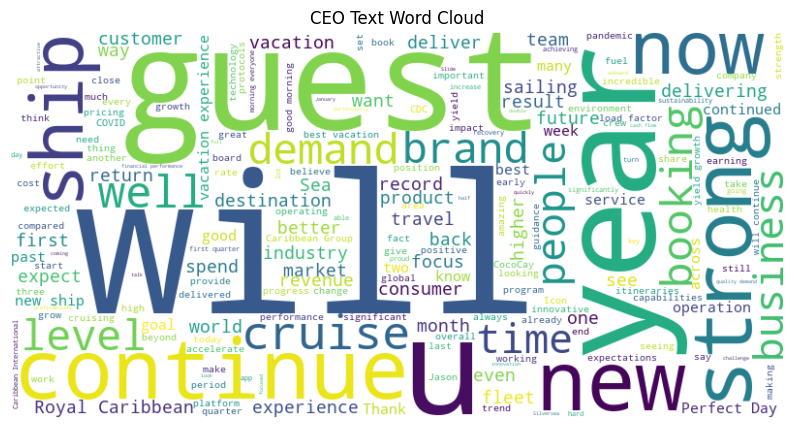

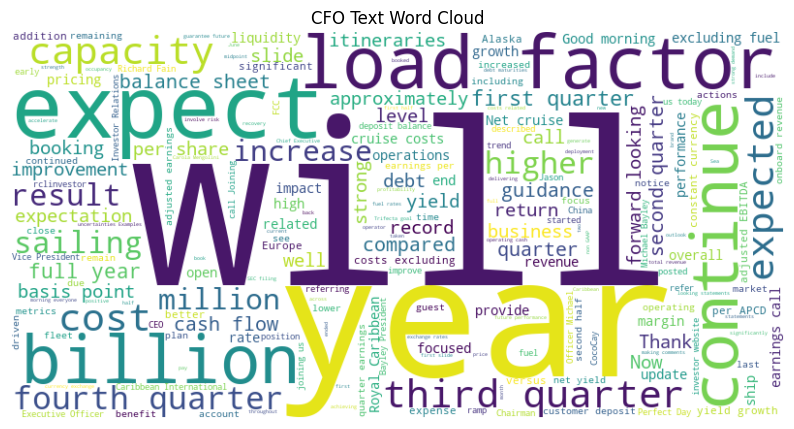

In [86]:
# Your DataFrame 'df' containing CEO and CFO text data
# (Assuming 'df' is already defined as per your provided data)

# Concatenate all CEO and CFO text data
ceo_text = ' '.join(df['CEO Text'])
cfo_text = ' '.join(df['CFO Text'])

# Generate word cloud for CEO text
plt.figure(figsize=(10, 6))
wordcloud_ceo = WordCloud(width=800, height=400, background_color='white').generate(ceo_text)
plt.imshow(wordcloud_ceo, interpolation='bilinear')
plt.title('CEO Text Word Cloud')
plt.axis('off')
plt.show()

# Generate word cloud for CFO text
plt.figure(figsize=(10, 6))
wordcloud_cfo = WordCloud(width=800, height=400, background_color='white').generate(cfo_text)
plt.imshow(wordcloud_cfo, interpolation='bilinear')
plt.title('CFO Text Word Cloud')
plt.axis('off')
plt.show()


### Pre-processing functions

In [87]:
# Ensure NLTK Stemmer is available
import nltk
nltk.download('stopwords')

# Initialize Stemmer
porter = SnowballStemmer("english")

# Function to strip special characters
def strip(word):
    return re.sub(r'\W+', '', word)

# Function to either keep abbreviations or lowercase words
def abbr_or_lower(word):
    return word if re.match('([A-Z]+[a-z]*){2,}', word) else word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
def tokenize(text, modulation):
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)

# Function to apply preprocessing to a DataFrame column
def preprocess_dataframe(df, text_column, mode):
    tqdm.pandas()  # Enable progress_apply for pandas
    df[f'preprocessed_{text_column}_data'] = df[text_column].astype(str).progress_apply(lambda x: tokenize(x, mode))
    return df

# Your actual DataFrame 'df'
# (Assuming 'df' is already defined as per your provided data)

# Apply preprocessing
mod = 1  # Set to 0 for just lowercase, 1 for stemming
df = preprocess_dataframe(df, 'CEO Text', mod)
df = preprocess_dataframe(df, 'CFO Text', mod)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\monbi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
100%|██████████| 22/22 [00:00<00:00, 230.54it/s]


In [ ]:
#initialize HIV4 (Harvard IV-4 dictionary)
hiv4 = ps.HIV4()

#function to get sentiment scores
def get_sentiment_scores(text):
    tokens = hiv4.tokenize(text)
    score = hiv4.get_score(tokens)
    return score

# # Apply sentiment analysis
# corpus_data['sentiment_scores'] =corpus_data['text_preproc'].apply(get_sentiment_scores)

# # Extract individual scores and create new columns
# corpus_data['Positive'] = corpus_data['sentiment_scores'].apply(lambda x: x['Positive'])
# corpus_data['Negative'] = corpus_data['sentiment_scores'].apply(lambda x: x['Negative'])
# corpus_data['Polarity'] = corpus_data['sentiment_scores'].apply(lambda x: x['Polarity'])
# corpus_data['Subjectivity'] = corpus_data['sentiment_scores'].apply(lambda x: x['Subjectivity'])

# # Add text length
# corpus_data['TextLength'] = corpus_data['text_preproc'].apply(len)


In [88]:
# # Vectorization using TF-IDF for CEO Text
# tfidf_vectorizer_ceo = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# tfidf_ceo = tfidf_vectorizer_ceo.fit_transform(df['preprocessed_CEO Text_data'])

# # LDA modeling for CEO Text
# num_topics = 5  # Specify the number of topics
# lda_model_ceo = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', random_state=42)
# lda_output_ceo = lda_model_ceo.fit_transform(tfidf_ceo)

# # Vectorization using TF-IDF for CFO Text
# tfidf_vectorizer_cfo = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# tfidf_cfo = tfidf_vectorizer_cfo.fit_transform(df['preprocessed_CFO Text_data'])

# # LDA modeling for CFO Text
# lda_model_cfo = LatentDirichletAllocation(n_components=num_topics, max_iter=10, learning_method='online', random_state=42)
# lda_output_cfo = lda_model_cfo.fit_transform(tfidf_cfo)

# # Function to display topics and their top keywords
# def display_topics(model, feature_names, no_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         print("Topic %d:" % (topic_idx + 1))
#         print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

# no_top_words = 10
# print("CEO Text Topics and their top keywords:")
# display_topics(lda_model_ceo, tfidf_vectorizer_ceo.get_feature_names_out(), no_top_words)
# print("\nCFO Text Topics and their top keywords:")
# display_topics(lda_model_cfo, tfidf_vectorizer_cfo.get_feature_names_out(), no_top_words)


CEO Text Topics and their top keywords:
Topic 1:
bring push secular expertis realli icon pandem appropri mention built
Topic 2:
product perfect day outstand demand realli mention ve delight kind
Topic 3:
cruis sail vacat everybodi produc cdc form recommend remain covid
Topic 4:
year doubl new guest week perfect spend thank destin end
Topic 5:
year continu guest cruis new strong book vacat deliv expect

CFO Text Topics and their top keywords:
Topic 1:
defin increas year termin pressur goal capabl grade strong deploy
Topic 2:
presid refer expect statement join richard look slide investor year
Topic 3:
talk maintain new miami carola lag custom term demand million
Topic 4:
year expect growth capac impact fuel q3 basi prior yield
Topic 5:
strengthen recap safeti discuss pleas presid richard websit free caribbean


In [92]:
# Function to perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity  # Get sentiment score
    return sentiment_score

# Apply sentiment analysis to CEO and CFO Text
df['CEO Sentiment'] = df['preprocessed_CEO Text_data'].apply(analyze_sentiment)
df['CFO Sentiment'] = df['preprocessed_CFO Text_data'].apply(analyze_sentiment)

# Display the DataFrame with sentiment scores
print("DataFrame with Sentiment Scores:")
print(df[['CEO Sentiment', 'CFO Sentiment']])

# Function to categorize sentiment as positive, negative, neutral, or undefined
def categorize_sentiment(score):
    if score is None:
        return 'Undefined'
    elif score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

# Apply sentiment categorization to CEO and CFO sentiment scores
df['CEO Sentiment Category'] = df['CEO Sentiment'].apply(categorize_sentiment)
df['CFO Sentiment Category'] = df['CFO Sentiment'].apply(categorize_sentiment)

# Display the DataFrame with sentiment categories
print("\nDataFrame with Sentiment Categories:")
print(df[['CEO Sentiment Category', 'CFO Sentiment Category']])

DataFrame with Sentiment Scores:
    CEO Sentiment  CFO Sentiment
20       0.163435       0.123929
18       0.239195       0.090774
5        0.229701       0.068237
0        0.186621       0.101970
1        0.187568       0.144667
2        0.184285       0.094483
3        0.282543       0.200113
4        0.211658       0.094691
6        0.199614       0.051927
7        0.206961       0.058982
8        0.164038       0.067056
9        0.081432       0.087500
10       0.180825       0.087500
11       0.146510       0.312500
12       0.169891       0.087500
13       0.141381       0.087500
14       0.156913       0.087500
15       0.127092       0.121753
16       0.000000       0.000000
17       0.511719       0.083791
19       0.283394       0.132440
21       0.160593       0.083791

DataFrame with Sentiment Categories:
   CEO Sentiment Category CFO Sentiment Category
20               Positive               Positive
18               Positive               Positive
5                Positi